In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
def guiyi(*fea):
    fea_matrix=np.array(fea[0])
    for f in fea:
        f=(f-f.min())/(f.max()-f.min()).reshape(-1,1)
        fea_matrix = np.hstack((fea_matrix,f))
    
    return fea_matrix[:,1:]

In [27]:
from utils.feature_extraction import find_peak_trough,feature_extraction
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from utils.data_splitter import get_sequence
from reciever import SEQ_LENGTH

scaler = MinMaxScaler()
file_list = listdir('data')
m = len(file_list)

train_features=np.empty([0,SEQ_LENGTH,6])
train_labels=np.empty([0,1])
test_features = np.empty([0, SEQ_LENGTH, 6])
test_labels=np.empty([0,1])

total_train_size=0

for i in range(m):
    if i % 3 == 1:
        continue
    file_name = './data/'+file_list[i]
    data = np.loadtxt(file_name, dtype=np.int16, skiprows=1)

    peaks, troughs = find_peak_trough(data, 54)
    f1, f2, f3, f4, f5, f8, f9, f10 = feature_extraction(
        data, peaks, troughs)

    train_size=int(f1.shape[0]*0.7)
    total_train_size+=train_size

    label=np.full((f1.shape[0],1),int(i%3>0)).reshape(-1,1) #  label=np.full((f1.shape[0],1), i%3).reshape(-1,1)

    # concated_matrix=np.hstack((f1,f3,f4,f5,f8,f9)) # 拼接起来的特征矩阵
    # concated_matrix=scaler.fit_transform(concated_matrix) # 经过归一化

    concated_matrix=guiyi(f1,f3,f4,f5,f8,f9) # 与上面两行同理

    fea_lab_matrix= np.hstack((concated_matrix,label)) # 特征-标签矩阵
    temporal_features , labels = get_sequence(data=fea_lab_matrix, seq_length=SEQ_LENGTH,device=device,to_device=False)
    
    train_features=np.vstack((train_features,temporal_features[:train_size]))
    train_labels=np.vstack((train_labels,labels[:train_size]))

    test_features=np.vstack((test_features,temporal_features[train_size:]))
    test_labels=np.vstack((test_labels,labels[train_size:]))

print(total_train_size)

8549


In [28]:
def analyze(labels,prediction,train_size,need_print=False):
    total_size = labels.shape[0]
    correct_prediction_in_train = sum(
        prediction[0:train_size] == labels[0:train_size])  # 训练集上正确预测的样本数
    correct_prediction_in_test = sum(
        prediction[train_size:] == labels[train_size:])  # 测试集上正确预测的样本数
    total_correct_prediction = correct_prediction_in_train + \
        correct_prediction_in_test  # 全体数据正确预测的样本数

    total_accuracy=total_correct_prediction/total_size
    train_accuracy=correct_prediction_in_train/train_size
    test_accuracy=correct_prediction_in_test/(total_size-train_size)

    if need_print:
        print("%-5d / %-5d = %.3f" % (total_correct_prediction, total_size, total_accuracy))
        print("%-5d / %-5d = %.3f" % (correct_prediction_in_train, train_size,train_accuracy ))
        print("%-5d / %-5d = %.3f" % (correct_prediction_in_test, total_size-train_size,test_accuracy ))

    return total_accuracy,train_accuracy,test_accuracy

In [29]:
train_features=torch.tensor(train_features).to(device).float()
train_labels=torch.tensor(train_labels).to(device)
test_features = torch.tensor(test_features).to(device).float()
test_labels=torch.tensor(test_labels).to(device)
total_features=torch.vstack((train_features,test_features))
total_labels=torch.vstack((train_labels,test_labels))

In [30]:
from utils.model import model
from utils.plot import plot
from reciever import INPUT_SIZE
from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./log')

num_epochs =10000

input_size=INPUT_SIZE
output_size=2
hidden_size=6
num_layers=5

lstm = model(input_size=input_size,output_size=output_size, hidden_size=hidden_size,num_layers=num_layers,device=device).to(device)
# writer.add_graph(lstm,torch.randn(10,3,6).to(device))  # 可视化的计算图

loss_function = torch.nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(lstm.parameters(), lr=0.001)

for epoch in range(num_epochs):
    epoch+=1
    prediction=lstm(train_features)
    
    trainY_one_hot=F.one_hot(train_labels.long()).float().squeeze()
    loss = loss_function( prediction,trainY_one_hot)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # writer.add_scalars('Loss',{"Train":loss.item()},epoch)

    if epoch % 100 == 0:

      lstm.eval()

      total_prediction=lstm(total_features)
      labels_one_hot=F.one_hot(total_labels.long()).float().squeeze()
      loss =loss_function(total_prediction,labels_one_hot)

      prediction_plot =total_prediction.cpu().detach().numpy().argmax(axis=1).reshape(-1,1)
      labels_plot=total_labels.cpu().numpy()

      total_accuracy,train_accuracy,test_accuracy=analyze(labels_plot, prediction_plot, total_train_size)

      # writer.add_scalars('Loss',{"Test":loss.item()},epoch)
      # writer.add_scalars('Acc', {"Total":total_accuracy,
      #                                    "Train": train_accuracy,
      #                                    "Test": test_accuracy}, epoch)
      print("Epoch : %5d | loss : %1.5f | total_acc : %1.5f | train_acc : %1.5f | test_acc : %1.5f" % (epoch, loss.item(),total_accuracy,train_accuracy,test_accuracy))

      lstm.train()

# writer.close()

Epoch :   100 | loss : 0.69134 | total_acc : 0.51161 | train_acc : 0.51140 | test_acc : 0.51212
Epoch :   200 | loss : 0.60400 | total_acc : 0.69100 | train_acc : 0.69973 | test_acc : 0.66995
Epoch :   300 | loss : 0.57422 | total_acc : 0.72555 | train_acc : 0.73588 | test_acc : 0.70068
Epoch :   400 | loss : 0.54628 | total_acc : 0.75829 | train_acc : 0.76933 | test_acc : 0.73168
Epoch :   500 | loss : 0.53045 | total_acc : 0.77499 | train_acc : 0.78559 | test_acc : 0.74944
Epoch :   600 | loss : 0.51629 | total_acc : 0.79028 | train_acc : 0.80185 | test_acc : 0.76240
Epoch :   700 | loss : 0.49866 | total_acc : 0.80871 | train_acc : 0.82091 | test_acc : 0.77931
Epoch :   800 | loss : 0.48209 | total_acc : 0.82541 | train_acc : 0.83671 | test_acc : 0.79820
Epoch :   900 | loss : 0.47480 | total_acc : 0.83484 | train_acc : 0.84525 | test_acc : 0.80975
Epoch :  1000 | loss : 0.46972 | total_acc : 0.84004 | train_acc : 0.84934 | test_acc : 0.81764
Epoch :  1100 | loss : 0.46472 | total_a

10418 / 12097 = 0.861
7500  / 8549  = 0.877
2918  / 3548  = 0.822


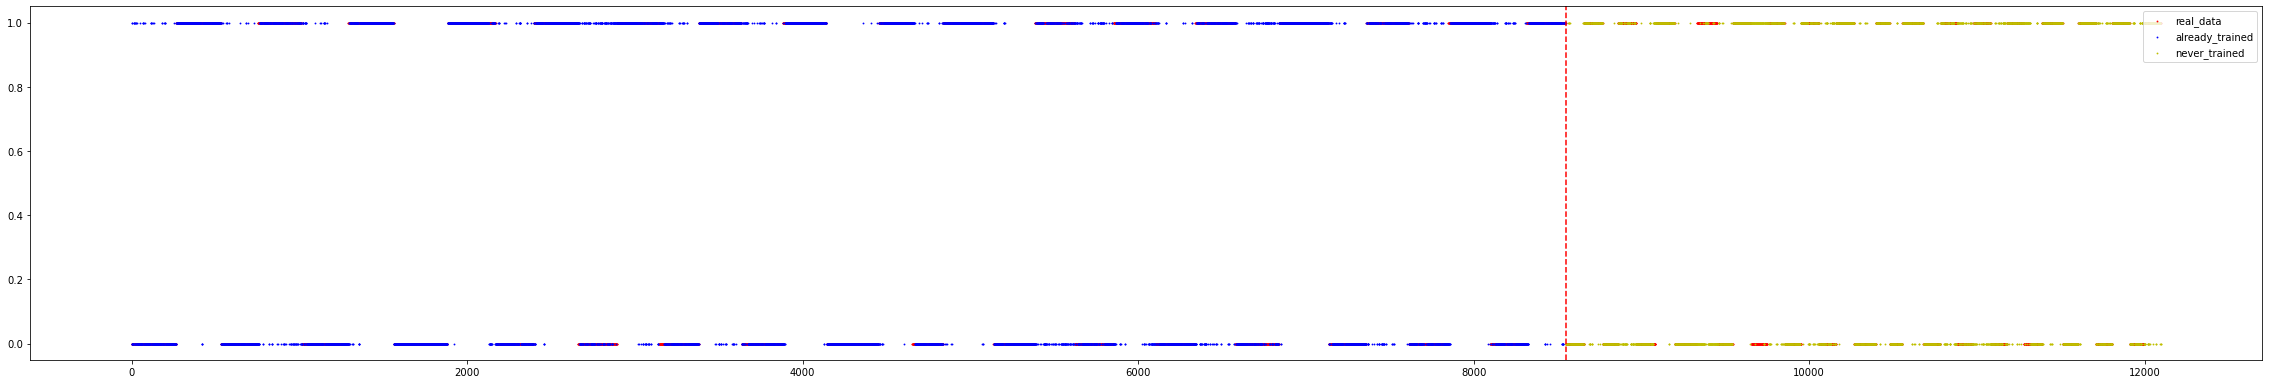

In [22]:
lstm.eval()

prediction = lstm(total_features)
prediction_plot = prediction.cpu().detach().numpy().argmax(axis=1).reshape(-1,1)

# lst=[]
# THETA=0.9
# weight_array=np.array([THETA**(i+1) for i in range(5)])
# print(weight_array)
# for i in range(3):
    # print(i)

labels_plot=total_labels.cpu().numpy()

analyze(labels_plot, prediction_plot, total_train_size,need_print=True)
plot(labels_plot,prediction_plot,total_train_size)

In [8]:
import os
if not os.path.exists('model'):
    os.mkdir('./model')

torch.save(lstm,'./model/lstm_neo_method.pkl')

In [24]:
loaded_model=torch.load('model/lstm_neo_method.pkl')
loaded_model

model(
  (lstm): LSTM(6, 6, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=6, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

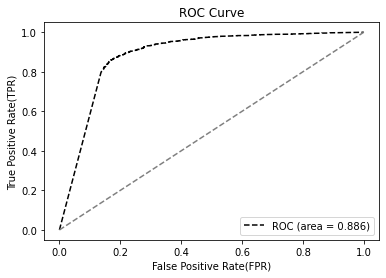

In [25]:
from sklearn import metrics

predictions=loaded_model(test_features)[:,1]

fpr, tpr, thersholds = metrics.roc_curve(test_labels.cpu().detach().numpy(),predictions.cpu().detach().numpy())

auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.3f})'.format(auc)) # ROC Curve
plt.plot([0,1],[0,1],linestyle='--',color='grey') # diagonal
 
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
predictions=loaded_model(test_features).argmax(axis=1)

#calculate metrics of model
acc = metrics.accuracy_score(test_labels.cpu().detach().numpy(),predictions.cpu().detach().numpy())
precision = metrics.precision_score(test_labels.cpu().detach().numpy(),predictions.cpu().detach().numpy())
recall = metrics.recall_score(test_labels.cpu().detach().numpy(),predictions.cpu().detach().numpy())
f1 = metrics.f1_score(test_labels.cpu().detach().numpy(),predictions.cpu().detach().numpy())

#print metrics
print("metrics are as follows:",end="")
print("""
      Accuracy: {}
     Precision: {}
        recall: {}
            F1: {}
           AUC: {}"""
                .format(acc,precision,recall,f1,auc))

metrics are as follows:
      Accuracy: 0.8416009019165727
     Precision: 0.846111417539989
        recall: 0.8442487616951018
            F1: 0.8451790633608814
           AUC: 0.8857565765523443
